<a href="https://colab.research.google.com/github/michalinajnk/Deep-Fake-Detection-in-Face-Images/blob/main/DeepFakeFace_10_51_6_12_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep fake detection in face images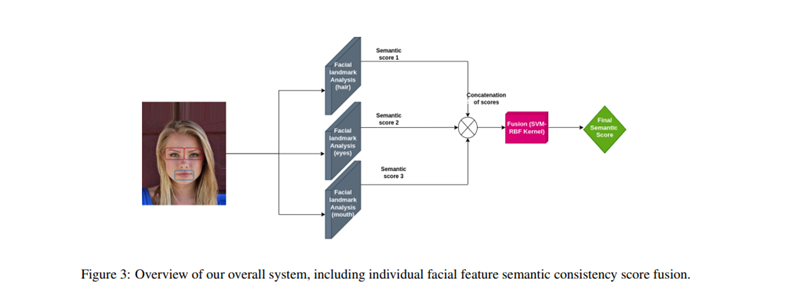

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
from pathlib import Path
root = '/content/gdrive/MyDrive/'
data_dirname = '/DeepFakeData/real_and_fake_face_300x300'
p = Path(root + data_dirname)
p.mkdir(exist_ok=True)

In [ ]:
!pip install fastbook --quiet
!pip install matplotlib
!pip install opencv-python
!pip install mediapipe
!pip install StandardScaler
!pip install keras-core
!pip install tensorflow
!pip install scikit-optimize

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

def get_params_for_training(filePath):
  image_size = (300, 300)
  batch_size = 2
  iterations_per_epoch = 10
  total_training_samples = os.listdir(filePath)
  num_epochs = total_training_samples / (batch_size * iterations_per_epoch)
  class_names = ['fake', 'real']
  return class_names, image_size, batch_size, iterations_per_epoch, num_epochs

Preprocessing and feature extraction form face images

In [ ]:

import cv2
import mediapipe as mp
import numpy as np
import dlib
import cv2
import numpy as np
from keras.models import load_model

nose_LANDMARK_POS = 30
mouth_LANDMARK_POS = 66
left_eye_LANDMARK_POS = 36 #36 to 41
right_eye_LANDMARK_POS = 47  # 42 to 47
hair_LANDMARK_POS = 16

class FacialFeatureExtractor:
    def __init__(self):
        self.face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
        self.target_size = 300, 300


    def extract_feature_from(self, image_path, landmark_pos):
        predictor_path = "/content/gdrive/MyDrive/DeepFakeData/predictor.dat"
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(predictor_path)
        image = cv2.imread(image_path)
        print(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        region = None
        for face in faces:
            landmarks = predictor(gray, face)
            x, y = landmarks.part(landmark_pos).x, landmarks.part(landmark_pos).y
            offset = 30
            x1, y1 = x - offset, y - offset
            x2, y2 = x + offset, y + offset
            region = image[y1:y2, x1:x2]
        return region

    def extract_feature_from_image(self, image, landmark_pos):
        predictor_path = "/content/gdrive/MyDrive/DeepFakeData/predictor.dat"
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(predictor_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        region = None
        for face in faces:
            landmarks = predictor(gray, face)
            x, y = landmarks.part(landmark_pos).x, landmarks.part(landmark_pos).y
            offset = 30
            x1, y1 = x - offset, y - offset
            x2, y2 = x + offset, y + offset
            region = image[y1:y2, x1:x2]
        return region

    def extract_mouth(self, image_path, threshold_percentage=0.2):
        predictor_path = "/content/gdrive/MyDrive/project/predictor.dat"
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(predictor_path)
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        mouth_region = None

        for face in faces:
            landmarks = predictor(gray, face)
            threshold_height = int(face.height() * threshold_percentage)
            threshold_width = int(face.width() * (1-threshold_percentage))

            for landmark_pos in range(48, 68):
                x, y = landmarks.part(landmark_pos).x, landmarks.part(landmark_pos).y

                offsetX = int(0.2 * face.width())
                offsetY = int(0.2 * face.height())
                x1, y1 = x - offsetX, y - offsetY
                x2, y2 = x + offsetX, y + offsetY

                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(face.width(), x2), min(face.height(), y2)

                mouth_region = image[y1:y2, x1:x2]

                # Check if the extracted region contains a reasonable mouth size (you can define a threshold)
                if mouth_region is not None and mouth_region.shape[0] > threshold_height and mouth_region.shape[1] > threshold_width:
                    break
        return mouth_region

    def extract_mouth_image(self, image, threshold_percentage=0.2):
        predictor_path = "/content/gdrive/MyDrive/project/predictor.dat"
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(predictor_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        mouth_region = None

        for face in faces:
            landmarks = predictor(gray, face)
            threshold_height = int(face.height() * threshold_percentage)
            threshold_width = int(face.width() * (1-threshold_percentage))

            for landmark_pos in range(48, 68):
                x, y = landmarks.part(landmark_pos).x, landmarks.part(landmark_pos).y

                offsetX = int(0.2 * face.width())
                offsetY = int(0.2 * face.height())
                x1, y1 = x - offsetX, y - offsetY
                x2, y2 = x + offsetX, y + offsetY

                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(face.width(), x2), min(face.height(), y2)

                mouth_region = image[y1:y2, x1:x2]

                # Check if the extracted region contains a reasonable mouth size (you can define a threshold)
                if mouth_region is not None and mouth_region.shape[0] > threshold_height and mouth_region.shape[1] > threshold_width:
                    break
        return mouth_region

    def extract_nose(self, image_path):
         return self.extract_feature_from(image_path, nose_LANDMARK_POS)

    def extract_left_eye(self, image_path):
        return self.extract_feature_from(image_path, left_eye_LANDMARK_POS)

    def extract_right_eye(self, image_path):
        return self.extract_feature_from(image_path, right_eye_LANDMARK_POS)

    def extract_nose_image(self, image):
         return self.extract_feature_from_image(image, nose_LANDMARK_POS)

    def extract_left_eye_image(self, image):
        return self.extract_feature_from_image(image, left_eye_LANDMARK_POS)

    def extract_right_eye_image(self, image):
        return self.extract_feature_from_image(image, right_eye_LANDMARK_POS)



    def extract_single_features(self, faceImagePath):
      hair_region = self.extract_hair(faceImagePath)
      nose = self.extract_nose(faceImagePath)
      mouth = self.extract_mouth(faceImagePath)
      return hair_region, nose, mouth

    def extract_both_eyes(self, faceImagePath):
      left_eye = self.extract_left_eye(faceImagePath)
      right_eye = self.extract_right_eye(faceImagePath)
      return left_eye, right_eye

    def getAllFeatures(self, faceImagePath):

      left_eye = self.extract_left_eye(faceImagePath)
      right_eye = self.extract_right_eye(faceImagePath)
      #hair_region = self.extract_hair(faceImagePath)
      nose = self.extract_nose(faceImagePath)
      mouth = self.extract_feature_from(faceImagePath, mouth_LANDMARK_POS)
      if left_eye is not None and right_eye is not None and mouth is not None and nose is not None:
        try:
          left_eye, right_eye, mouth, nose = resize_to([left_eye, right_eye, mouth, nose])
          return left_eye, right_eye, mouth, nose
        except:
          return None, None, None, None

    def get_all_features_from_image(self, img):
      left_eye = self.extract_left_eye_image(img)
      right_eye = self.extract_right_eye_image(img)
      #hair_region = self.extract_hair(faceImagePath)
      nose = self.extract_nose_image(img)
      mouth = self.extract_feature_from_image(img, mouth_LANDMARK_POS)
      left_eye, right_eye, mouth, nose = resize_to([left_eye, right_eye, mouth, nose])
      return left_eye, right_eye, mouth, nose



Create model baseline (pretrained model to use)
---

EfficentNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_feature_extractor2(input_shape):
      # Here you define your EfficientNet as a feature extractor
      base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
      base_model.trainable = False
      return base_model


def create_feature_extractor(input_shape):
      base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        classifier_activation="softmax",
      )
      base_model.trainable = False
      return base_model



Single Feature analysis (mouth, hair)

In [ ]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, Flatten,BatchNormalization, AveragePooling2D
from tensorflow.keras import Model
import numpy as np

# Assuming create_feature_extractor is a function that returns an EfficientNet model and its output shape.

from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class SingleFeatureAnalysisModel(keras.Model):
    def __init__(self, input_shape=(300, 300, 3), cut_off=False):
        super(SingleFeatureAnalysisModel, self).__init__()
        self.cut_off = cut_off
        self.efficientnet_extractor = create_feature_extractor(input_shape)
        # Initial convolutional layers with input shape
        self.conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')
        self.avgPool2D = AveragePooling2D(pool_size=(2, 2), strides=1, padding='same')
        self.batchNorm = BatchNormalization()

        # Following layers do not need the input_shape
        self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')
        self.conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')
        self.conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')
        self.flatten = Flatten()
        self.fc1 = Dense(256, activation='relu')
        self.fc2 = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.efficientnet_extractor(inputs)
        print(f' efficientnet_extractor shape {np.shape(x)}')
        x = self.conv1(x)
        print(f' conv1 {np.shape(x)}')
        x = self.avgPool2D(x)
        print(f' avgPool2D {np.shape(x)}')
        x = self.batchNorm(x)
        print(f' batchNorm {np.shape(x)}')
        x = self.conv2(x)
        print(f' conv2 {np.shape(x)}')
        x = self.conv3(x)
        print(f' conv3 {np.shape(x)}')
        x = self.conv4(x)
        print(f' conv4 {np.shape(x)}')
        x = self.conv5(x)
        print(f' conv5 {np.shape(x)}')
        x = self.conv6(x)
        print(f' conv6 {np.shape(x)}')
        x = self.avgPool2D(x)
        print(f' avgPool2D {np.shape(x)}')
        x = self.batchNorm(x)
        print(f"Before cutting off the last layers shape, Single model : {np.shape(x)}")

        if not self.cut_off:
          x = self.flatten(x)
          print(f"flatten : {np.shape(x)}")
          x = self.fc1(x)
          print(f"fc1 : {np.shape(x)}")
          x = self.fc2(x)
          print(f"fc2 : {np.shape(x)}")

        return x

# Instantiate the model using the input shape
model = SingleFeatureAnalysisModel(input_shape=(300, 300, 3))

# Get the functional Model instance using the model's input and output
inputs = Input(shape=(300, 300, 3))
outputs = model(inputs)
modelSingleFeature = Model(inputs=inputs, outputs=outputs)

# Compile and print the summary
modelSingleFeature.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
modelSingleFeature.summary()




 efficientnet_extractor shape (None, 10, 10, 1280)
 conv1 (None, 10, 10, 256)
 avgPool2D (None, 10, 10, 256)
 batchNorm (None, 10, 10, 256)
 conv2 (None, 10, 10, 64)
 conv3 (None, 10, 10, 128)
 conv4 (None, 10, 10, 256)
 conv5 (None, 10, 10, 256)
 conv6 (None, 10, 10, 256)
 avgPool2D (None, 10, 10, 256)
Before cutting off the last layers shape, Single model : (None, 10, 10, 256)
flatten : (None, 25600)
fc1 : (None, 256)
fc2 : (None, 1)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 single_feature_analysis_mo  (None, 1)                 13459201  
 del_19 (SingleFeatureAnaly                                      
 sisModel)                                                       
                                                                 
Total params: 1

Two-feature comparative analysis model (eyes)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class TwoFeatureComparativeAnalysisModel(keras.Model):
    def __init__(self, input_shape=((300, 300, 3), (300, 300, 3))):
        super(TwoFeatureComparativeAnalysisModel, self).__init__()
        self.left_eye_model = SingleFeatureAnalysisModel(input_shape[0], cut_off=True)
        self.right_eye_model = SingleFeatureAnalysisModel(input_shape[1], cut_off=True)

        self.conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1))
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2), padding='same')
        self.conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1))
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2), padding='same')
        self.conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1))
        self.maxpool3 = MaxPooling2D(pool_size=(2, 2), padding='same')
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(1, activation='sigmoid')

    def call(self, eye_inputs):
        left, right = eye_inputs
        left_eye_features = self.left_eye_model(left)
        right_eye_features = self.right_eye_model(right)
        print("Shape left_eye:", left_eye_features.shape)
        print("Shape right eye:", right_eye_features.shape)


        combined_features = Lambda(euclidean_distance)([left_eye_features, right_eye_features])
        #combined_features = Concatenate(axis=-1)([left_eye_features, right_eye_features])

        print("Shape after concatenation:", combined_features.shape)

        x = self.conv1(combined_features)
        print("Shape after conv1:", x.shape)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)

        print("Shape before flatten:", x.shape)  # Adjusted this print statement
        x = self.flatten(x)

        x = self.dense1(x)
        output = self.dense2(combined_features)

        return output



In [ ]:
def preprocess_additionally_img(img, desired_shape=(300,300)):
  img = tf.image.resize(img, desired_shape)
  img = img.astype('float32')
  return np.expand_dims(img, axis=0)

In [ ]:
def resize_to(images, desired_shape=(300,300)):
  for image in images:
    image = tf.image.resize(image, desired_shape)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension #(60,60)
  return images

In [ ]:
'''



feature_extractor = FacialFeatureExtractor()
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
left_eye, right_eye, mouth, nose = feature_extractor.getAllFeatures("/content/gdrive/MyDrive/DeepFakeData/face.jpg");
#left_eye, right_eye, mouth, nose = feature_extractor.getAllFeatures("/content/gdrive/MyDrive/project/face.jpg");


#cv2.imwrite("/hair_path.jpg", hair_region.astype(np.uint8))
cv2.imwrite("/mouth_path.jpg", mouth.astype(np.uint8))
cv2.imwrite("/nose_path.jpg", nose.astype(np.uint8))
cv2.imwrite("/left_eye_path.jpg", left_eye.astype(np.uint8))
cv2.imwrite("/right_eye_path.jpg", right_eye.astype(np.uint8))




model = SingleFeatureAnalysisModel(input_shape=(300, 300, 3))
inputs = Input(shape=(300, 300, 3))
outputs = model(inputs)
modelSingleFeature = Model(inputs=inputs, outputs=outputs)

# Compile and print the summary
modelSingleFeature.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
modelSingleFeature.summary()


left_eye_input = Input(shape=(300, 300, 3))
right_eye_input = Input(shape=(300, 300, 3))
modelTwoFeature = TwoFeatureComparativeAnalysisModel(input_shape=((300, 300, 3), (300, 300, 3)))
outputs = modelTwoFeature([left_eye_input, right_eye_input])
final_model_two_feature = Model(inputs=[left_eye_input, right_eye_input], outputs=outputs)
final_model_two_feature.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
final_model_two_feature.summary()






# Compile the model (you can choose an appropriate optimizer and loss function)
modelSingleFeature.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])


# Resize the images to a larger size (e.g., 300x300)
desired_input_size = (300, 300)


left_eye = cv2.resize(left_eye, desired_input_size)
left_eye = np.expand_dims(left_eye.astype('float32'), axis=0)

right_eye = cv2.resize(right_eye, desired_input_size)
right_eye = np.expand_dims(right_eye.astype('float32'), axis=0)

nose = cv2.resize(nose, desired_input_size)
nose = np.expand_dims(nose.astype('float32') , axis=0)

mouth = cv2.resize(mouth, desired_input_size)
mouth = np.expand_dims(mouth.astype('float32'), axis=0)


similarity_score_eyes = modelTwoFeature([left_eye, right_eye])
similarity_score_nose = modelSingleFeature(nose)
similarity_score_mouth = modelSingleFeature(mouth)


###WE NEED TO TRAIN THE NEURAL NETWORK TO CALCULATE IT CORRECTLY
# Print the similarity score
print(f'Similarity Score for eyes: {np.mean(similarity_score_eyes)}')
#print(f'Similarity Score for hairs: {np.mean(similarity_score_hair_region)}')
print(f'Similarity Score for nose: {np.mean(similarity_score_nose)}')
print(f'Similarity Score for mouth: {np.mean(similarity_score_mouth)}')


'''

'\n\n\n\nfeature_extractor = FacialFeatureExtractor()\n# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nleft_eye, right_eye, mouth, nose = feature_extractor.getAllFeatures("/content/gdrive/MyDrive/DeepFakeData/face.jpg");\n#left_eye, right_eye, mouth, nose = feature_extractor.getAllFeatures("/content/gdrive/MyDrive/project/face.jpg");\n\n\n#cv2.imwrite("/hair_path.jpg", hair_region.astype(np.uint8))\ncv2.imwrite("/mouth_path.jpg", mouth.astype(np.uint8))\ncv2.imwrite("/nose_path.jpg", nose.astype(np.uint8))\ncv2.imwrite("/left_eye_path.jpg", left_eye.astype(np.uint8))\ncv2.imwrite("/right_eye_path.jpg", right_eye.astype(np.uint8))\n\n\n\n\nmodel = SingleFeatureAnalysisModel(input_shape=(300, 300, 3))\ninputs = Input(shape=(300, 300, 3))\noutputs = model(inputs)\nmodelSingleFeature = Model(inputs=inputs, outputs=outputs)\n\n# Compile and print the summary\nmodelSingleFeature.compile(optimizer=\'adam\', loss=\'binary_crossentropy\', metrics=[tf.keras.metrics.BinaryAccuracy()])\nmodelSingleFea

Fusion of the concatenated semantic scores for mouth, eyes and hair and nose

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
import os

class SemanticScoreFusion:
    def __init__(self):
        self.feature_scores = []  # List to store feature-level scores
        self.svm_classifier = None
        self.scaler = StandardScaler()  # Initialize the scaler

    def add_feature_scores(self, scores):
        self.feature_scores.extend(scores)

    def train_svm(self, labels):
        if not self.feature_scores:
            raise ValueError("No feature-level scores added for training.")

        if len(self.feature_scores) != len(labels):
            raise ValueError("Number of feature-level scores must match the number of labels.")

        X = np.array(self.feature_scores)
        X = self.scaler.fit_transform(X)

        # Train an SVM classifier with Platt scaling
        svm_classifier = SVC(kernel='rbf', probability=True)
        calibrated_svm = CalibratedClassifierCV(svm_classifier, method='sigmoid')
        calibrated_svm.fit(X, labels)

        self.svm_classifier = calibrated_svm

    def predict_image_authenticity(self, feature_scores):
      """
      Predict the image-level authenticity and confidence scores using the trained SVM.
      :param feature_scores: List of feature-level scores for a new image
      :return: Tuple (authenticity: 0 for synthetic, 1 for real, confidence: probability of correctness)
      """
      if self.svm_classifier is None:
        raise ValueError("SVM classifier is not trained. Call train_svm() before making predictions.")

      # Transform the feature scores with the saved scaler
      X = self.scaler.transform(np.array([feature_scores]))

      # Predict the image-level authenticity and confidence scores
      prob_real = self.svm_classifier.predict_proba(X)[:, 1]

      # Make a binary decision based on the predicted probability
      authenticity = 1 if prob_real >= 0.5 else 0
      confidence = prob_real if authenticity else 1 - prob_real

      return authenticity, confidence

CODE DOWNSTAIRS WAS DONE TO  CREATE A RTREE STRUCTURE OF FILES OF EXTRACTED FEATURES

In [ ]:
# Preprocessing

"""
!pip install tensorflow.keras
import json
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
import logging
import cv2

feature_extractor = FacialFeatureExtractor()


json_file_path = '/content/gdrive/MyDrive/DeepFakeData/Images.json'
base_directory = '/content/gdrive/MyDrive/DeepFakeData/real_and_fake_face_300x300'
single_feature_dir = '/content/gdrive/MyDrive/DeepFakeData/single_features'
multiple_feature_dir = '/content/gdrive/MyDrive/DeepFakeData/multiple_features'
subdirectories = ['train', 'validation', 'test']



logging.basicConfig(level=logging.INFO)


try:
    with open(json_file_path, 'r') as file:
        labeled_data = json.load(file)
except Exception as e:
    logging.error(f"Error loading JSON file: {e}")
    exit()

for subdirectory in subdirectories:
    directory_path = os.path.join(base_directory, subdirectory)

    single_feature_output_dir = os.path.join(single_feature_dir, subdirectory)
    multiple_feature_output_dir = os.path.join(multiple_feature_dir, subdirectory)

    os.makedirs(single_feature_output_dir, exist_ok=True)
    os.makedirs(multiple_feature_output_dir, exist_ok=True)

    label_subdirectories = ['fake', 'real']
    for label_subdirectory in label_subdirectories:
        label_directory_path = os.path.join(directory_path, label_subdirectory)

        try:
            files = os.listdir(label_directory_path)
        except Exception as e:
            logging.error(f"Error listing directory {label_directory_path}: {e}")
            continue

        image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_file in image_files:
            image_path = os.path.join(label_directory_path, image_file)
            try:
                left_eye, right_eye, mouth, nose = feature_extractor.getAllFeatures(image_path)

                if image_file in labeled_data:
                  # Save single features
                  #hair_path = os.path.join(single_feature_output_dir, label_subdirectories[labeled_data[image_file][0]], f'hair_{image_file}')

                  # Save multiple features
                  left_eye_path = os.path.join(multiple_feature_output_dir, label_subdirectories[labeled_data[image_file][1]], f'left_eye_{image_file}')
                  print(f"Left eye path: {left_eye_path}")
                  right_eye_path = os.path.join(multiple_feature_output_dir, label_subdirectories[labeled_data[image_file][1]], f'right_eye_{image_file}')
                  print(f"Right eye path: {right_eye_path}")

                  mouth_path = os.path.join(single_feature_output_dir, label_subdirectories[labeled_data[image_file][2]], f'mouth_{image_file}')
                  print(f"Mouth path {mouth_path}")
                  nose_path = os.path.join(single_feature_output_dir, label_subdirectories[labeled_data[image_file][3]], f'nose_{image_file}')
                  print(f"Nose path {mouth_path}")
                else:
                  # Save single features
                  #hair_path = os.path.join(single_feature_output_dir, label_subdirectory, f'hair_{image_file}')
                  mouth_path = os.path.join(single_feature_output_dir, label_subdirectory, f'mouth_{image_file}')
                  print(f"Mouth path {mouth_path}")
                  nose_path = os.path.join(single_feature_output_dir, label_subdirectory, f'nose_{image_file}')
                  print(f"Nose path {mouth_path}")

                  # Save multiple features
                  left_eye_path = os.path.join(multiple_feature_output_dir, label_subdirectory, f'left_eye_{image_file}')
                  print(f"Left eye path: {left_eye_path}")
                  right_eye_path = os.path.join(multiple_feature_output_dir, label_subdirectory, f'right_eye_{image_file}')
                  print(f"Right eye path: {right_eye_path}")

                # Save the features
                if mouth is not None and mouth.size > 0:
                  cv2.imwrite(mouth_path, mouth.astype(np.uint8))
                  print("Was able to save the mouth region from the image")

                if nose is not None and nose.size > 0:
                  cv2.imwrite(nose_path, nose.astype(np.uint8))
                  print("Was able to save the nose region from the image")
                if left_eye is not None and left_eye.size > 0:
                  cv2.imwrite(left_eye_path, left_eye.astype(np.uint8))
                  print("Was able to save the left eye region from the image")

                if right_eye is not None and right_eye.size > 0:
                  cv2.imwrite(right_eye_path, right_eye.astype(np.uint8))
                  print("Was able to save the right eye region from the image")

            except Exception as e:
                logging.error(f"Error processing image {image_path}: {e}")
                continue

            logging.info(f"Features processed for image: {image_path}")

"""


'\n!pip install tensorflow.keras\nimport json\nfrom mpl_toolkits.mplot3d import Axes3D\nfrom sklearn.preprocessing import StandardScaler\nimport matplotlib.pyplot as plt # plotting\nimport numpy as np # linear algebra\nimport os # accessing directory structure\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\nimport tensorflow as tf\nfrom tensorflow.keras.applications.xception import preprocess_input\nfrom tensorflow.keras.utils import image_dataset_from_directory\nimport logging\nimport cv2\n\nfeature_extractor = FacialFeatureExtractor()\n\n\njson_file_path = \'/content/gdrive/MyDrive/DeepFakeData/Images.json\'\nbase_directory = \'/content/gdrive/MyDrive/DeepFakeData/real_and_fake_face_300x300\'\nsingle_feature_dir = \'/content/gdrive/MyDrive/DeepFakeData/single_features\'\nmultiple_feature_dir = \'/content/gdrive/MyDrive/DeepFakeData/multiple_features\'\nsubdirectories = [\'train\', \'validation\', \'test\']\n\n\n\nlogging.basicConfig(level=logging.INFO)\n\n\nt

RUN TO CREATE DATASETS FOR FEATURES MODELS

In [ ]:


'''
# Preprocessing
!pip install tensorflow.keras
import json
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
import logging
import cv2

image_size = (300, 300)
batch_size = 32
class_names = ['fake', 'real']

def get_file_paths_with_labels(directory_path):
    files_fake = get_files_from_directory(os.path.join(directory_path, 'fake'))
    files_real = get_files_from_directory(os.path.join(directory_path, 'real'))

    # Create a list of labels corresponding to the files
    labels_fake = [0] * len(files_fake)  # Assuming label '0' for 'fake'
    labels_real = [1] * len(files_real)  # Assuming label '1' for 'real'

    # Concatenate file paths and labels
    image_paths = files_fake + files_real
    labels = labels_fake + labels_real

    return image_paths, labels

def get_files_from_directory(directory_path):
    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Directory does not exist: {directory_path}")
        return []

    # List all files and directories in the specified path
    files_and_directories = os.listdir(directory_path)

    # If you want only files and not directories, you can filter them out
    files = [f for f in files_and_directories if os.path.isfile(os.path.join(directory_path, f))]

    return files


train_data_directory_single = '/content/gdrive/MyDrive/DeepFakeData/single_features/train'
validation_data_directory_single = '/content/gdrive/MyDrive/DeepFakeData/single_features/validation'
test_data_directory_single = '/content/gdrive/MyDrive/DeepFakeData/single_features/test'



#SINGLE MODEL
# Training dataset
train_dataset_single = image_dataset_from_directory(
    train_data_directory_single,
    labels='inferred',
    label_mode='binary',
    class_names=class_names,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=43,
)

# Validation dataset
validation_dataset_single = image_dataset_from_directory(
    validation_data_directory_single,
    labels='inferred',
    label_mode='binary',
    class_names=class_names,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle for validation data
    seed=49,
)

# Test dataset
test_dataset_single = image_dataset_from_directory(
    test_data_directory_single,
    labels='inferred',
    label_mode='binary',
    class_names=class_names,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle for test data
    seed=42,
)


train_data_directory_multiple_fake = '/content/gdrive/MyDrive/DeepFakeData/multiple_features/train/fake'
validation_data_directory_multiple_fake = '/content/gdrive/MyDrive/DeepFakeData/multiple_features/validation/fake'
test_data_directory_multiple_fake = '/content/gdrive/MyDrive/DeepFakeData/multiple_features/test/fake'

train_data_directory_multiple_real = '/content/gdrive/MyDrive/DeepFakeData/multiple_features/train/real'
validation_data_directory_multiple_real = '/content/gdrive/MyDrive/DeepFakeData/multiple_features/validation/real'
test_data_directory_multiple_real = '/content/gdrive/MyDrive/DeepFakeData/multiple_features/test/real'





def get_pair_of_eyes_dir(eyes_files, label, train_data_directory_root):
    # Initialize a list to hold all pairs
    all_pairs = {}
    # Create dictionaries to hold the files
    left_eye_files = {}
    right_eye_files = {}

    # Populate dictionaries with the files, using the substring as the key
    for file in eyes_files:
        if 'left_eye_' in file:
            key = file.split('left_eye_')[1]  # Get the unique identifier substring
            left_eye_files[key] = os.path.join(train_data_directory_root, file)
        elif 'right_eye_' in file:
            key = file.split('right_eye_')[1]  # Get the unique identifier substring
            right_eye_files[key] =  os.path.join(train_data_directory_root, file)

    for key in left_eye_files:
      if key in right_eye_files:
        all_pairs[(left_eye_files[key], right_eye_files[key])] = label

    print(all_pairs)
    return all_pairs


def get_file_paths_with_labels(directory_path):
    files_fake = get_files_from_directory(os.path.join(directory_path, 'fake'))
    files_real = get_files_from_directory(os.path.join(directory_path, 'real'))

    # Create a list of labels corresponding to the files
    labels_fake = [0] * len(files_fake)  # Assuming label '0' for 'fake'
    labels_real = [1] * len(files_real)  # Assuming label '1' for 'real'

    # Concatenate file paths and labels
    image_paths = files_fake + files_real
    labels = labels_fake + labels_real

    return image_paths, labels





  ### CHANGING THE STRUCTURE OF THE BASE FOR THE TRAINING FOR EYES TO HAVE the eyes in the array together anbt the label as the value )
eyes_train_files_fake = get_files_from_directory(train_data_directory_multiple_fake)
eyes_validation_files_fake = get_files_from_directory(validation_data_directory_multiple_fake)
eyes_test_files_fake = get_files_from_directory(test_data_directory_multiple_fake)

eyes_with_labels_train_fake = get_pair_of_eyes_dir(eyes_train_files_fake, 'fake', train_data_directory_multiple_fake )
eyes_with_labels_validation_fake = get_pair_of_eyes_dir(eyes_validation_files_fake, 'fake', validation_data_directory_multiple_fake)
eyes_with_labels_test_fake = get_pair_of_eyes_dir(eyes_test_files_fake, 'fake', test_data_directory_multiple_fake)



# Get the list of files from each directory
eyes_train_files_real = get_files_from_directory(train_data_directory_multiple_real)
eyes_validation_files_real = get_files_from_directory(validation_data_directory_multiple_real)
eyes_test_files_real = get_files_from_directory(test_data_directory_multiple_real)

# Get pairs of eyes with 'real' labels
eyes_with_labels_train_real = get_pair_of_eyes_dir(eyes_train_files_real, 'real', train_data_directory_multiple_real)
eyes_with_labels_validation_real = get_pair_of_eyes_dir(eyes_validation_files_real, 'real', train_data_directory_multiple_real)
eyes_with_labels_test_real = get_pair_of_eyes_dir(eyes_test_files_real, 'real', train_data_directory_multiple_real)




# Training dataset
train_dict_multiple = {**eyes_with_labels_train_fake, **eyes_with_labels_train_real}
validation_dict_multiple = {**eyes_with_labels_validation_fake, **eyes_with_labels_validation_real}
test_dict_multiple = {**eyes_with_labels_test_fake, **eyes_with_labels_test_real}








def preprocess_image(image, label):
    image = preprocess_input(image)
    return image, label





import tensorflow as tf

# Convert categorical labels to numerical labels
label_to_index = {'fake': 0, 'real': 1}
train_data = [((left_eye, right_eye), label_to_index[label]) for (left_eye, right_eye), label in train_dict_multiple.items()]
validation_data = [((left_eye, right_eye), label_to_index[label]) for (left_eye, right_eye), label in validation_dict_multiple.items()]
test_data = [((left_eye, right_eye), label_to_index[label]) for (left_eye, right_eye), label in test_dict_multiple.items()]

print("Train data")
print(train_data)

def data_generator(data):
  for (left_eye_path, right_eye_path), label in data:
    left_eye_image = cv2.imread(left_eye_path)
    right_eye_image = cv2.imread(right_eye_path)
    if left_eye_image is not None and right_eye_image is not None :
      left_eye_image = cv2.resize(left_eye_image, (300, 300))
      right_eye_image = cv2.resize(right_eye_image, (300, 300))
      left_eye_image = preprocess_input(left_eye_image)
      right_eye_image = preprocess_input(right_eye_image)
      yield (left_eye_image, right_eye_image), label
    continue





# Create dataset objects using the generator
train_dataset_multiple = tf.data.Dataset.from_generator(lambda: data_generator(train_data),
                                                        output_types=((tf.float32, tf.float32), tf.int32))
validation_dataset_multiple = tf.data.Dataset.from_generator(lambda: data_generator(validation_data),
                                                             output_types=((tf.float32, tf.float32), tf.int32))
test_dataset_multiple = tf.data.Dataset.from_generator(lambda: data_generator(test_data),
                                                       output_types=((tf.float32, tf.float32), tf.int32))



shuffle_buffer_size = len(train_dict_multiple)  # You can adjust this
train_data_directory_multiple = '/content/gdrive/MyDrive/DeepFakeData/multiple_features'
batch_size_mult = 32
seed = 42


# Batch, shuffle, and prefetch
train_dataset_multiple = train_dataset_multiple.batch(batch_size_mult).shuffle(buffer_size=shuffle_buffer_size, seed=seed).prefetch(tf.data.AUTOTUNE)
validation_dataset_multiple = validation_dataset_multiple.batch(batch_size_mult).shuffle(buffer_size=shuffle_buffer_size, seed=seed).prefetch(tf.data.AUTOTUNE)
test_dataset_multiple = test_dataset_multiple.batch(batch_size_mult).shuffle(buffer_size=shuffle_buffer_size, seed=seed).prefetch(tf.data.AUTOTUNE)


for feat, lab in train_dataset_single.take(1):
    # If features is a single tensor
    print("Features shape:", feat.shape)
    # If labels is a single tensor
    print("Labels shape:", lab.shape)


for (feat1, feat2), labels in train_dataset_multiple.take(1):
    # If features is a single tensor
    print("Features shape 1:", feat1.shape)
    print("Features shape 2:", feat2.shape)
    # If labels is a single tensor
    print("Labels:", labels)



# Apply preprocessing to the datasets SINGLE MODEL
train_dataset_single = train_dataset_single.map(preprocess_image)
validation_dataset_single = validation_dataset_single.map(preprocess_image)
test_dataset_single = test_dataset_single.map(preprocess_image)







'''

'\n# Preprocessing\n!pip install tensorflow.keras\nimport json\nfrom mpl_toolkits.mplot3d import Axes3D\n\nfrom sklearn.preprocessing import StandardScaler\nimport matplotlib.pyplot as plt # plotting\nimport numpy as np # linear algebra\nimport os # accessing directory structure\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\nimport tensorflow as tf\nfrom tensorflow.keras.applications.mobilenet_v2 import preprocess_input\nfrom tensorflow.keras.utils import image_dataset_from_directory\nimport logging\nimport cv2\n\nimage_size = (300, 300)\nbatch_size = 32\nclass_names = [\'fake\', \'real\']\n\ndef get_file_paths_with_labels(directory_path):\n    files_fake = get_files_from_directory(os.path.join(directory_path, \'fake\'))\n    files_real = get_files_from_directory(os.path.join(directory_path, \'real\'))\n\n    # Create a list of labels corresponding to the files\n    labels_fake = [0] * len(files_fake)  # Assuming label \'0\' for \'fake\'\n    labels_real = [1]

Training models with features

In [ ]:
"""

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

model = SingleFeatureAnalysisModel(input_shape=(300, 300, 3))
inputs = Input(shape=(300, 300, 3))
outputs = model(inputs)
modelSingleFeature = Model(inputs=inputs, outputs=outputs)

# Compile and print the summary
modelSingleFeature.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
modelSingleFeature.summary()


left_eye_input = Input(shape=(300, 300, 3))
right_eye_input = Input(shape=(300, 300, 3))

modelTwoFeature = TwoFeatureComparativeAnalysisModel(input_shape=((300, 300, 3), (300, 300, 3)))
outputs = modelTwoFeature([left_eye_input, right_eye_input])
final_model_two_feature = Model(inputs=[left_eye_input, right_eye_input], outputs=outputs)
final_model_two_feature.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
final_model_two_feature.summary()



def get_current_time():
    return datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

my_callbacks_single = [
    tf.keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True, start_from_epoch=6, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'/content/gdrive/MyDrive/DeepFakeData/single_feature_model_{get_current_time()}.keras', save_weights_only=True,  monitor='val_accuracy',  mode='max'),
]

my_callbacks_multiple = [
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1, restore_best_weights=True, start_from_epoch=2, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'/content/gdrive/MyDrive/DeepFakeData/two_feature_model_{get_current_time()}.keras', save_weights_only=True,  monitor='val_accuracy',  mode='max'),

]

# Training single feature model
history_single = modelSingleFeature.fit(
    train_dataset_single,
    epochs=20,
    verbose=1,
    validation_data=validation_dataset_single,
    callbacks=my_callbacks_single
)



modelSingleFeature.save(filepath=f'/content/gdrive/MyDrive/DeepFakeData/final_single_feature_model_{get_current_time()}.keras')



history_two_feature = final_model_two_feature.fit(
    train_dataset_multiple,
    epochs=20,
    verbose=1,
    validation_data=validation_dataset_multiple,
    callbacks=my_callbacks_multiple
)


final_model_two_feature.save(filepath=f'/content/gdrive/MyDrive/DeepFakeData/final_two_feature_model_{get_current_time()}.keras')





"""

'\n\nfrom keras.optimizers import Adam\nfrom keras.callbacks import ModelCheckpoint, EarlyStopping\nfrom datetime import datetime\n\nmodel = SingleFeatureAnalysisModel(input_shape=(300, 300, 3))\ninputs = Input(shape=(300, 300, 3))\noutputs = model(inputs)\nmodelSingleFeature = Model(inputs=inputs, outputs=outputs)\n\n# Compile and print the summary\nmodelSingleFeature.compile(optimizer=\'adam\', loss=\'binary_crossentropy\', metrics=[tf.keras.metrics.BinaryAccuracy()])\nmodelSingleFeature.summary()\n\n\nleft_eye_input = Input(shape=(300, 300, 3))\nright_eye_input = Input(shape=(300, 300, 3))\n\nmodelTwoFeature = TwoFeatureComparativeAnalysisModel(input_shape=((300, 300, 3), (300, 300, 3)))\noutputs = modelTwoFeature([left_eye_input, right_eye_input])\nfinal_model_two_feature = Model(inputs=[left_eye_input, right_eye_input], outputs=outputs)\nfinal_model_two_feature.compile(optimizer=\'adam\', loss=\'binary_crossentropy\', metrics=[tf.keras.metrics.BinaryAccuracy()])\nfinal_model_two_f

CREATE DATASETS, LOADING PICTURES FROM FILEPATHS, FOR SVM AND LOAD MODELS FOR TRIANING THE SVM


In [ ]:
'''
##################################################
####WROOOONG ATTEMPT UNCECESSARY EXTRACTION#


import numpy as np
from sklearn.svm import SVC
from tensorflow import keras
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score
import os
import tensorflow as tf
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.saving import load_model



feature_extractor = FacialFeatureExtractor()


modelTwoFeature = load_model('/content/gdrive/MyDrive/DeepFakeData/final_two_feature_model2023-11-30_17:34:19.keras',
                             custom_objects={'TwoFeatureComparativeAnalysisModel': TwoFeatureComparativeAnalysisModel})


modelSingleFeature =  load_model('/content/gdrive/MyDrive/DeepFakeData/final_single_feature_model_2023-12-03_12-32-26.keras',
                                 custom_objects={'SingleFeatureAnalysisModel': SingleFeatureAnalysisModel})


train_data_directory = '/content/gdrive/MyDrive/DeepFakeData/real_and_fake_face_300x300/train'
validation_data_directory = '/content/gdrive/MyDrive/DeepFakeData/real_and_fake_face_300x300/validation'
test_data_directory = '/content/gdrive/MyDrive/DeepFakeData/real_and_fake_face_300x300/test'


batch_size = 32
image_size = (300, 300)
class_names = ['fake', 'real']
img_path_map = {}
images = []


def get_files_from_directory(directory_path):
    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Directory does not exist: {directory_path}")
        return []

    files_and_directories = os.listdir(directory_path)
    files = [f for f in files_and_directories if os.path.isfile(os.path.join(directory_path, f))]
    return files


def load_image(image_path):
    try:
        image_path = tf.compat.as_str_any(image_path)
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Image not found or unable to read: {image_path}")
        print(f'Success, Image path is: {image_path}')
        return img
    except Exception as e:
        print(f'Failed to read, Image path is: {image_path}, Error: {e}')
        return None


def adjust(image, image_size):
    image = cv2.resize(image, image_size)
    image = preprocess_input(image)  # Make sure this function is defined correctly
    return image


def get_first_key_by_value(my_dict, value_to_find):
    for key, value in my_dict.items():
        if value == value_to_find:
            return key
    return None


def get_file_paths_with_labels(directory_path):
    fake_images_filePath = os.path.join(directory_path, 'fake')
    real_images_filePath = os.path.join(directory_path, 'real')
    files_fake = get_files_from_directory(fake_images_filePath)
    print(f'File path fake {fake_images_filePath}')
    files_real = get_files_from_directory(real_images_filePath)
    print(f'File path real {real_images_filePath}')

    # Create a list of labels corresponding to the files
    labels_fake = [0] * len(files_fake)  # Assuming label '0' for 'fake'
    labels_real = [1] * len(files_real)  # Assuming label '1' for 'real'

    # Concatenate file paths and labels
    image_paths = files_fake + files_real
    labels = labels_fake + labels_real
    return image_paths, labels


def load_images_and_paths(directory, image_size, batch_size):
    image_paths, labels = get_file_paths_with_labels(directory)
    for index, image_path in enumerate(image_paths):
        label_name = 'fake' if labels[index] == 0 else 'real'
        path = os.path.join(os.path.join(directory, label_name), image_path)
        image = load_image(path)
        if image is None:
            continue

        image = adjust(image, image_size)
        images.append(image)
        img_path_map[path] = index

    images_ds = tf.data.Dataset.from_tensor_slices(images)
    labels_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int64))
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = ds.batch(batch_size)
    return ds


def adjust_feature(left_eye, size):
  left_eye = cv2.resize(left_eye, size)
  left_eye = np.expand_dims(left_eye.astype('float32'), axis=0)
  return left_eye


train_dataset = load_images_and_paths(train_data_directory, image_size, batch_size)
validation_dataset = load_images_and_paths(validation_data_directory, image_size, batch_size)
test_dataset = load_images_and_paths(test_data_directory, image_size, batch_size)
'''

In [ ]:
base_path = '/content/gdrive/MyDrive/DeepFakeData'
feature_extractor = FacialFeatureExtractor()

modelTwoFeature = load_model('/content/gdrive/MyDrive/DeepFakeData/final_two_feature_model2023-11-30_17:34:19.keras',
                             custom_objects={'TwoFeatureComparativeAnalysisModel': TwoFeatureComparativeAnalysisModel})


modelSingleFeature =  load_model('/content/gdrive/MyDrive/DeepFakeData/final_single_feature_model_2023-12-03_12-32-26.keras',
                                 custom_objects={'SingleFeatureAnalysisModel': SingleFeatureAnalysisModel})


In [ ]:

def Take_Feature_For_Face(base_path):
    categories = ["train", "validation", "test"]
    types = ["fake", "real"]
    matched_sets = {'train': [], 'validation': [], 'test': []}

    for category in categories:
        for type_ in types:
            multiple_features_path = os.path.join('/content/gdrive/MyDrive/DeepFakeData/multiple_features', category, type_)
            single_features_path = os.path.join('/content/gdrive/MyDrive/DeepFakeData/single_features', category, type_)

            left_eyes = glob.glob(os.path.join(multiple_features_path, "left_eye_*"))
            right_eyes = glob.glob(os.path.join(multiple_features_path, "right_eye_*"))
            print(f'Left eyes found in number {len(left_eyes)}')
            print(f'Right eyes found in number {len(right_eyes)}')

            # Extract substrings from filenames
            left_eye_substrings = {os.path.basename(le)[9:]: le for le in left_eyes}
            right_eye_substrings = {os.path.basename(re)[10:]: re for re in right_eyes}

            for key in left_eye_substrings:
                print(f'The substring from left_eye needs to befound in right eye: {key}')
                if key in right_eye_substrings:
                    # Match nose and mouth features with the same substring
                    nose_path = os.path.join(single_features_path, f"nose_{key}")
                    mouth_path = os.path.join(single_features_path, f"mouth_{key}")

                    if os.path.exists(nose_path) and os.path.exists(mouth_path):
                        # Read and process each image
                        left_eye_img = cv2.imread(left_eye_substrings[key])
                        right_eye_img = cv2.imread(right_eye_substrings[key])
                        nose_img = cv2.imread(nose_path)
                        mouth_img = cv2.imread(mouth_path)

                        if all(img is not None for img in [left_eye_img, right_eye_img, nose_img, mouth_img]):
                            # Resize and preprocess images
                            processed_imgs = [cv2.resize(img, (300, 300)) for img in [left_eye_img, right_eye_img, nose_img, mouth_img]]
                            processed_imgs = [np.expand_dims((img.astype('float32')), axis=0) for img in processed_imgs]

                            label = 0 if type_ == "fake" else 1
                            matched_set = (*processed_imgs, label)
                            matched_sets[category].append(matched_set)

    return matched_sets



def preprocess_features(feature_sets):
    score_vectors = []
    labels = []
    counter_of_pictures = 0
    counter_of_score_vectors = 0
    counter_of_labels = 0
    try:
        for (left_eye, right_eye, nose, mouth, label) in feature_sets:
          counter_of_pictures +=1
          print(f'{counter_of_pictures} feature set is proceed')
          try:
            # Calculate semantic scores using the trained models
            eyes_score = modelTwoFeature.predict([left_eye, right_eye])
            nose_score = modelSingleFeature.predict(nose)
            mouth_score = modelSingleFeature.predict(mouth)
            # Combine scores into a single vector
            score_vector = np.hstack((np.mean(eyes_score), np.mean(nose_score), np.mean(mouth_score)))
            counter_of_score_vectors += 1
            print(f'{score_vector} nr {counter_of_score_vectors}. score vector of the feature set')

            score_vectors.append(score_vector)
            labels.append(label)
            print('SUCCESS')

          except Exception as e:
            print(f'Error in predicting the fakeness of the feature: {e}')
            continue

        return np.array(score_vectors), np.array(labels)

    except Exception as e:
      print(f'Error in preprocess_features: {e}')

    finally:
       return np.array(score_vectors), np.array(labels)


# Define the hyperparameter space for the SVC classifier
search_space = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['rbf']),
}


# Configuration for ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/gdrive/MyDrive/DeepFakeData/fused_SVM_model.{epoch:02d}-{val_loss:.2f}.keras',  # Change the file path as needed
    save_best_only=True,  # Only save a model if `val_loss` has improved
    monitor='val_loss',  # Monitor 'val_loss' to determine the best model
    mode='min',  # The 'min' mode means the callback will monitor the minimum value of 'val_loss'
    verbose=1
)


match_sets = Take_Feature_For_Face(base_path)

# Preprocess and extract features from datasets
train_score_vectors, train_labels = preprocess_features(match_sets['train'])
val_score_vectors, val_labels = preprocess_features(match_sets['validation'])
test_score_vectors, test_labels = preprocess_features(match_sets['test'])

print(f'Train score vector length {len(train_score_vectors)}')
print(f'Val score vector length {len(val_score_vectors)}')



Instead of extracting feature once more time, we can map the extracted one already and map them if they belong to the same image


In [ ]:
import os
import glob
import cv2
import numpy as np
from sklearn.svm import SVC
from tensorflow import keras
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score
import os
import tensorflow as tf
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.saving import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

####################GOOOD ATTEMPT#########



# Combine the training and validation datasets for cross-validation
X_combined = np.vstack((train_score_vectors, val_score_vectors))
y_combined = np.concatenate((train_labels, val_labels))

# Define a splitter that uses the validation set for hyperparameter tuning
# The validation set indices are set to 0 and the rest are set to -1
# PredefinedSplit takes an array of integers, where the indices set to 0 will be the validation fold
test_fold = [-1]*len(train_score_vectors) + [0]*len(val_score_vectors)
ps = PredefinedSplit(test_fold)

# Create an instance of the BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=SVC(probability=True),
    search_spaces=search_space,
    n_iter=32,  # Number of iterations
    scoring='accuracy',  # You can choose other metrics like 'roc_auc'
    n_jobs=-1,  # Use all available cores
    cv=ps,  # Use the predefined split
    random_state=42,
    verbose=3  # Higher number gives more print-outs
)



# Fit the BayesSearchCV to find the best hyperparameters using the combined dataset
history = bayes_search.fit(X_combined, y_combined)


print(f"Best parameters found: {bayes_search.best_params_}")
best_svm_classifier = bayes_search.best_estimator_
from joblib import dump, load

# Save the best SVM classifier to a file
dump(best_svm_classifier, '/content/gdrive/MyDrive/DeepFakeData/best_svm_classifier.keras')

test_predictions = best_svm_classifier.predict(test_score_vectors)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test accuracy: {test_accuracy}")
print(classification_report(test_labels, test_predictions, target_names=class_names))


def adjust_feature(left_eye, size):
  left_eye = cv2.resize(left_eye, size)
  left_eye = np.expand_dims(left_eye.astype('float32'), axis=0)
  return left_eye

image_size = (300, 300)

def calculate_semantic_scores(image):
    try:
        left_eye, right_eye, mouth, nose = feature_extractor.get_all_features_from_image(image)
        if left_eye is None or right_eye is None or mouth is None or nose is None:
            raise ValueError("Feature extraction failed")
        else:
          left_eye = adjust_feature(left_eye, image_size)
          right_eye = adjust_feature(right_eye,image_size)
          mouth = adjust_feature(mouth, image_size)
          nose = adjust_feature(nose, image_size)

          # Calculate semantic scores using the trained models
          eyes_score = modelTwoFeature.predict([left_eye, right_eye])
          nose_score = modelSingleFeature.predict(nose)
          mouth_score = modelSingleFeature.predict(mouth)

          print(f'Eyes Score Shape: {eyes_score.shape}')
          print(f'Nose Score Shape: {nose_score.shape}')
          print(f'Mouth Score Shape: {mouth_score.shape}')
          # Combine scores into a single vector
          score_vector = np.hstack((np.mean(eyes_score), np.mean(nose_score), np.mean(mouth_score)))
          return score_vector

    except Exception as e:
        print(f'Error in calculate_semantic_scores for image {image}: {e}')
        return np.hstack([0.5, 0.5, 0.5])  # Return a default vector or handle as needed


# For prediction on new data
def predict_authenticity(new_image):
    best_svm_classifier = load('/content/gdrive/MyDrive/DeepFakeData/best_svm_classifier.keras')
    new_score_vector = calculate_semantic_scores(new_image)
    authenticity = best_svm_classifier.predict(new_score_vector.reshape(1, -1))
    confidence = best_svm_classifier.predict_proba(new_score_vector.reshape(1, -1))[0][authenticity]
    return authenticity, confidence


# Function to calculate F1 score on a test dataset
def evaluate_on_test_data(model):
    test_score_vectors, test_labels = preprocess_features(match_sets['test'])
    test_predictions = model.predict(test_score_vectors)
    # Calculate F1 score
    f1 = f1_score(test_labels, test_predictions)
    return f1

 efficientnet_extractor shape (None, 10, 10, 1280)
 conv1 (None, 10, 10, 256)
 avgPool2D (None, 10, 10, 256)
 batchNorm (None, 10, 10, 256)
 conv2 (None, 10, 10, 64)
 conv3 (None, 10, 10, 128)
 conv4 (None, 10, 10, 256)
 conv5 (None, 10, 10, 256)
 conv6 (None, 10, 10, 256)
 avgPool2D (None, 10, 10, 256)
Before cutting off the last layers shape, Single model : (None, 10, 10, 256)
 efficientnet_extractor shape (None, 10, 10, 1280)
 conv1 (None, 10, 10, 256)
 avgPool2D (None, 10, 10, 256)
 batchNorm (None, 10, 10, 256)
 conv2 (None, 10, 10, 64)
 conv3 (None, 10, 10, 128)
 conv4 (None, 10, 10, 256)
 conv5 (None, 10, 10, 256)
 conv6 (None, 10, 10, 256)
 avgPool2D (None, 10, 10, 256)
Before cutting off the last layers shape, Single model : (None, 10, 10, 256)
Shape left_eye: (None, 10, 10, 256)
Shape right eye: (None, 10, 10, 256)
Shape after concatenation: (None, 1, 10, 256)
Shape after conv1: (None, 1, 10, 64)
Shape before flatten: (None, 1, 2, 256)
 efficientnet_extractor shape (None, 10,

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
1/1 [==============================] - 0s 26ms/step
[0.38541034 0.9699285  0.99515873] nr 805. score vector of the feature set
SUCCESS
806 feature set is proceed
1/1 [==============================] - 0s 25ms/step
[0.43623662 0.9970668  0.99629635] nr 806. score vector of the feature set
SUCCESS
807 feature set is proceed
1/1 [==============================] - 0s 24ms/step
[0.5710517  0.993511   0.99438196] nr 807. score vector of the feature set
SUCCESS
808 feature set is proceed
1/1 [==============================] - 0s 26ms/step
[0.41770345 0.9805751  0.993054  ] nr 808. score vector of the feature set
SUCCESS
809 feature set is proceed
1/1 [==============================] - 0s 25ms/step
[0.36254787 0.99262685 0.99358565] nr 809. score vector of the feature set
SUCCESS
810 feature set is proceed
1/1 [==============================] - 0s 24ms/step
[0.36376405 0.9947956  0.99601436] nr 810. score vector of the feature se

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


USE CREATED DATASET AND LOADED MODELS AND CREATE A PIPELINE TO TRAIN THE SVM

In [ ]:
'''
##################################################
####WROOOONG ATTEMPT UNCECESSARY EXTRACTION#



import numpy as np
from sklearn.svm import SVC
from tensorflow import keras
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score
import os
import tensorflow as tf
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.saving import load_model



def calculate_semantic_scores(index):
    try:
        image_path = get_first_key_by_value(img_path_map, index)
        print(f'Mapped filePath of the picture {image_path} ')
        left_eye, right_eye, mouth, nose = feature_extractor.getAllFeatures(image_path)
        if left_eye is None or right_eye is None or mouth is None or nose is None:
            raise ValueError("Feature extraction failed")
        else:
          left_eye = adjust_feature(left_eye, image_size)
          right_eye = adjust_feature(right_eye,image_size)
          mouth = adjust_feature(mouth, image_size)
          nose = adjust_feature(nose, image_size)

          # Calculate semantic scores using the trained models
          eyes_score = modelTwoFeature.predict([left_eye, right_eye])
          nose_score = modelSingleFeature.predict(nose)
          mouth_score = modelSingleFeature.predict(mouth)

          print(f'Eyes Score Shape: {eyes_score.shape}')
          print(f'Nose Score Shape: {nose_score.shape}')
          print(f'Mouth Score Shape: {mouth_score.shape}')
          # Combine scores into a single vector
          score_vector = np.hstack((np.mean(eyes_score), np.mean(nose_score), np.mean(mouth_score)))
          return score_vector

    except Exception as e:
        print(f'Error in calculate_semantic_scores for image {image_path}: {e}')
        return np.hstack([0.5, 0.5, 0.5])  # Return a default vector or handle as needed



def preprocess_and_extract_features(dataset):
    score_vectors = []
    labels = []
    for ind_batch, (batch, label_batch) in enumerate(dataset):
        batch = preprocess_input(batch)
        for index, (image, label) in enumerate(zip(batch, label_batch)):
            score_vector = calculate_semantic_scores(index + ind_batch*batch_size )
            score_vectors.append(score_vector)
            print(label)
            labels.append(label.numpy())  # Assuming binary labels
    return np.array(score_vectors), np.array(labels)



# Preprocess and extract features from datasets
train_score_vectors, train_labels = preprocess_and_extract_features(train_dataset)
val_score_vectors, val_labels = preprocess_and_extract_features(validation_dataset)
test_score_vectors, test_labels = preprocess_and_extract_features(test_dataset)



# Combine the training and validation datasets for cross-validation
X_combined = np.vstack((train_score_vectors, val_score_vectors))
y_combined = np.concatenate((train_labels, val_labels))

# Define a splitter that uses the validation set for hyperparameter tuning
# The validation set indices are set to 0 and the rest are set to -1
# PredefinedSplit takes an array of integers, where the indices set to 0 will be the validation fold
test_fold = [-1]*len(train_score_vectors) + [0]*len(val_score_vectors)
ps = PredefinedSplit(test_fold)



# Define the hyperparameter space for the SVC classifier
search_space = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['rbf']),
}



# Create an instance of the BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=SVC(probability=True),
    search_spaces=search_space,
    n_iter=32,  # Number of iterations
    scoring='accuracy',  # You can choose other metrics like 'roc_auc'
    n_jobs=-1,  # Use all available cores
    cv=ps,  # Use the predefined split
    random_state=42,
    verbose=3  # Higher number gives more print-outs
)


# Configuration for ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/gdrive/MyDrive/DeepFakeData/fused_SVM_model.{epoch:02d}-{val_loss:.2f}.keras',  # Change the file path as needed
    save_best_only=True,  # Only save a model if `val_loss` has improved
    monitor='val_loss',  # Monitor 'val_loss' to determine the best model
    mode='min',  # The 'min' mode means the callback will monitor the minimum value of 'val_loss'
    verbose=1
)

# Fit the BayesSearchCV to find the best hyperparameters using the combined dataset
history = bayes_search.fit(X_combined, y_combined,  callbacks=[model_checkpoint_callback])


print(f"Best parameters found: {bayes_search.best_params_}")
best_svm_classifier = bayes_search.best_estimator_
from joblib import dump, load

# Save the best SVM classifier to a file
dump(best_svm_classifier, '/content/gdrive/MyDrive/DeepFakeData/best_svm_classifier.keras')

test_predictions = best_svm_classifier.predict(test_score_vectors)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test accuracy: {test_accuracy}")
print(classification_report(test_labels, test_predictions, target_names=class_names))


# For prediction on new data
def predict_authenticity(new_image):
    best_svm_classifier = load('/content/gdrive/MyDrive/DeepFakeData/best_svm_classifier.keras')
    new_score_vector = calculate_semantic_scores(new_image)
    authenticity = best_svm_classifier.predict(new_score_vector.reshape(1, -1))
    confidence = best_svm_classifier.predict_proba(new_score_vector.reshape(1, -1))[0][authenticity]
    return authenticity, confidence


# Function to calculate F1 score on a test dataset
def evaluate_on_test_data(test_dataset, model):
    test_score_vectors, test_labels = preprocess_and_extract_features(test_dataset)
    test_predictions = model.predict(test_score_vectors)

    # Calculate F1 score
    f1 = f1_score(test_labels, test_predictions)
    return f1
    '''

Plot accuracy, confusion matrix, curve,

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_accuracy_for(history)
  training_accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']
  training_loss = history.history['loss']
  validation_loss = history.history['val_loss']

  # Plot the training and validation accuracy
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(training_accuracy, label='Training Accuracy')
  plt.plot(validation_accuracy, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  # Plot the training and validation loss
  plt.subplot(1, 2, 2)
  plt.plot(training_loss, label='Training Loss')
  plt.plot(validation_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

def evaluate_model(model, test_dataset):

  loss, accuracy = model.evaluate(test_dataset, verbose=1)
  print(f'Test Loss: {loss:.4f}')
  print(f'Test Accuracy: {accuracy:.4f}')

  # Generate predictions
  y_pred = model.predict(test_dataset)
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_true_classes = test_dataset.classes

  # Plot confusion matrix
  conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  # Print classification report
  class_report = classification_report(y_true_classes, y_pred_classes, target_names=test_dataset.class_indices.keys())
  print('Classification Report:\n', class_report)


***USAGE OF ENSEMBLE LEARNING:***

> 1. Load ResNet rrained model
2. Load SVM classifier
3. Caclculate their weights in the final score based on there performance on some set of images
4. Ensemble them but simple avaraging the reuslt.
5. Set the threshold for fake and real
6. Assess the label for the picture based on its score and the threshold





In [ ]:
from tensorflow.keras.models import load_model


best_svm_classifier = load('/content/gdrive/MyDrive/DeepFakeData/best_svm_classifier.keras')
best_resnet_classifier = load_model('/content/gdrive/MyDrive/DeepFakeData/resnet_best_noHard_e=20_b=32_lr=-5.keras')

# Evaluate the model on the test dataset
f1_score_SVM = evaluate_on_test_data(test_dataset, best_svm_classifier)
print(f"F1 Score on Test Data: {f1_score}")



####ASSESSING DANIELS MODEL#################################
true_labels = []
predictions = []

for batch_features, batch_labels in test_dataset:
    true_labels.extend(batch_labels.numpy())
    batch_predictions = model.predict(batch_features)
    predictions.extend(np.round(batch_predictions).astype(int))


f1_score_resnet = f1_score(true_labels, predictions)


total_f1 = f1_score_SVM + f1_score_resnet
weight_for_model_SVM = f1_score_SVM / total_f1
weight_for_model_RESNET = f1_score_resnet / total_f1


def weighted_ensemble_predict(input_data, model1, model2, weight1, weight2):
    pred1 = model1.predict(input_data)
    pred2 = model2.predict(input_data)

    # Apply weights and average the predictions
    weighted_pred = (weight1 * pred1 + weight2 * pred2) / (weight1 + weight2)

    final_pred = (weighted_pred > 0.5).astype(int)  # For binary classification
    return final_pred



image_to_test = cv2.imread('/content/gdrive/MyDrive/DeepFakeData/face.jpeg')
# Use this function for predictions
image_to_test = preprocess_additionally_img(image_to_test)
ensemble_predictions = weighted_ensemble_predict(image_to_test, best_svm_classifier, best_resnet_classifier, weight_for_model_SVM, weight_for_model_RESNET)

